<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mohammad Amin Molaei 
### Student ID: 402012018

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,StandardScaler


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Define the MNIST dataset and data loader

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 183497273.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 28382308.77it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 34739432.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7623260.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [4]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

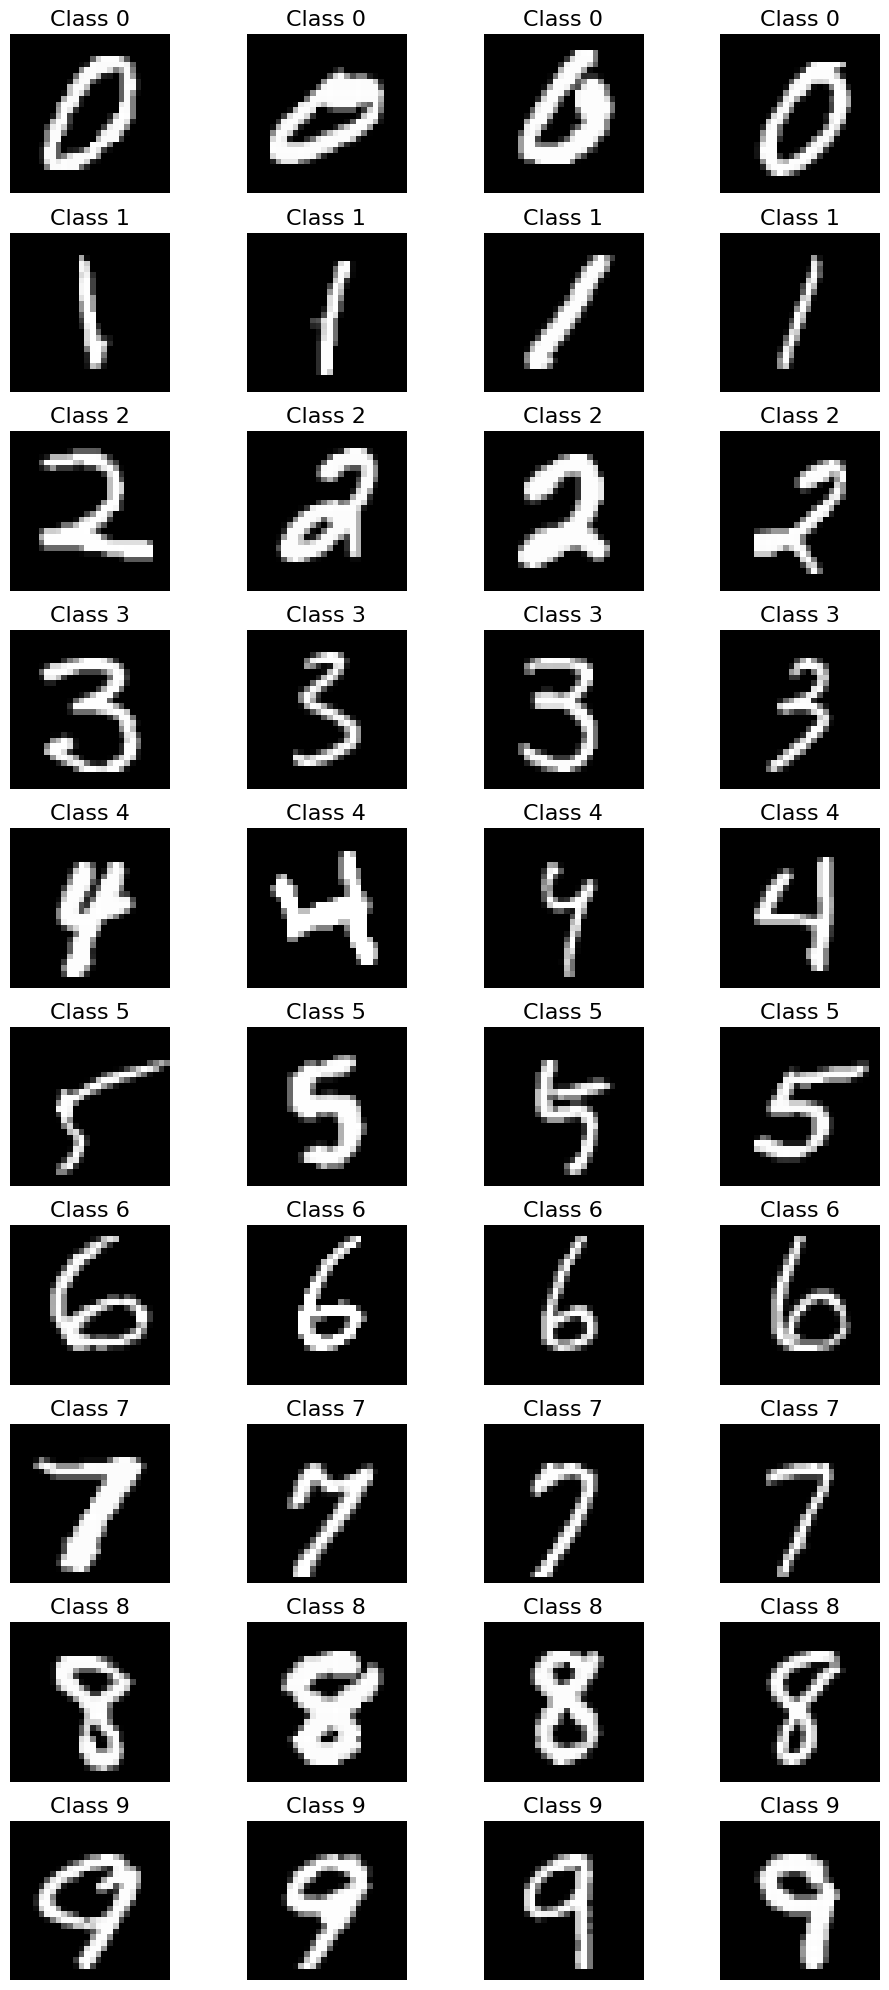

In [5]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_MLP(nn.Module):
    def __init__(self, input_dim = 784 , hidden_dims = [256 , 64] , latent_dim = 2):
        super(VAE_MLP, self).__init__()
        self.latent_dim = latent_dim
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )
        
        # Latent space layers
        self.fc_mu = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[1], latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim),
            nn.Sigmoid()  # Sigmoid activation for binary data (0-1 range)
        )

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x_encoded = self.encoder(x)
        
        # Latent space
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        
        # Reparameterization
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        x_decoded = self.decoder(z)

        return x_decoded, mu, logvar


In [8]:
def vae_loss(recon, data, mu, logvar):
    # Reconstruction loss (binary cross-entropy for binary data)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_loss + kl_divergence

    return total_loss


In [10]:
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process
            data = data.to(device)
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            data = data.view(-1, 784)
            recon = recon.view(-1, 784)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, model.latent_dim)
                sample = model.decoder(sample.to(device)).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/20], Loss: 182.8441
Sample Images:


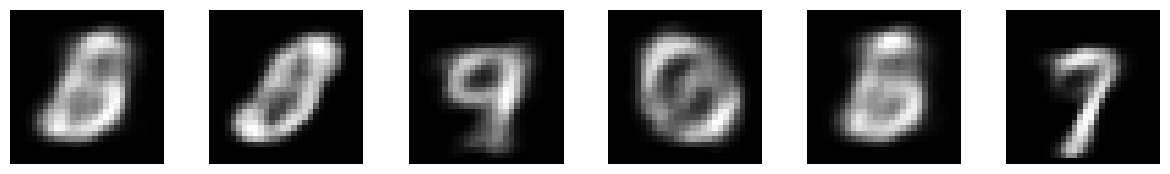


##################################################
VAE-MLP Epoch [2/20], Loss: 163.1687
Sample Images:


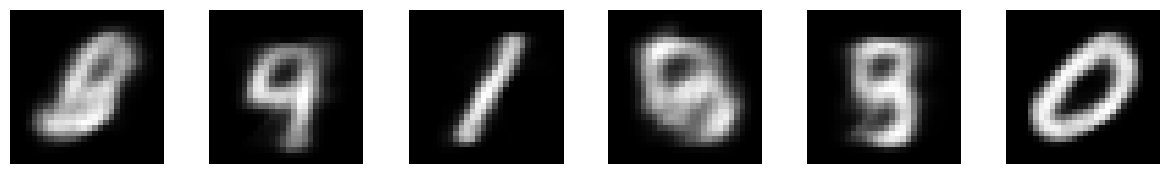


##################################################
VAE-MLP Epoch [3/20], Loss: 157.2845
Sample Images:


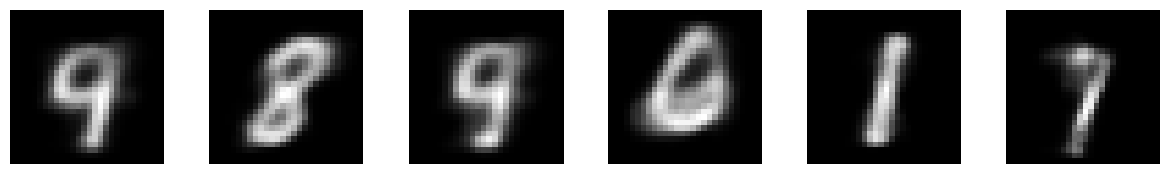


##################################################
VAE-MLP Epoch [4/20], Loss: 153.5842
Sample Images:


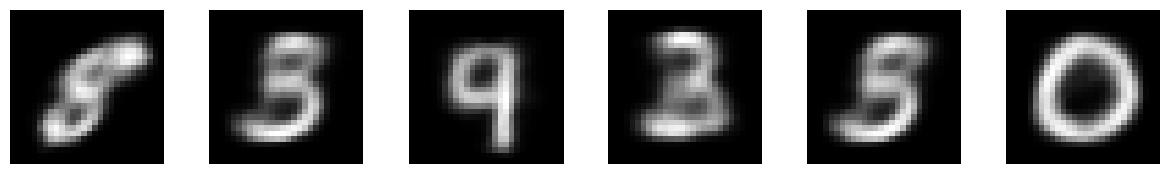


##################################################
VAE-MLP Epoch [5/20], Loss: 151.1415
Sample Images:


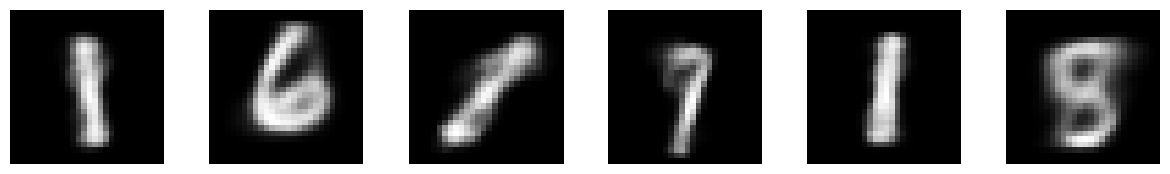


##################################################
VAE-MLP Epoch [6/20], Loss: 149.2589
Sample Images:


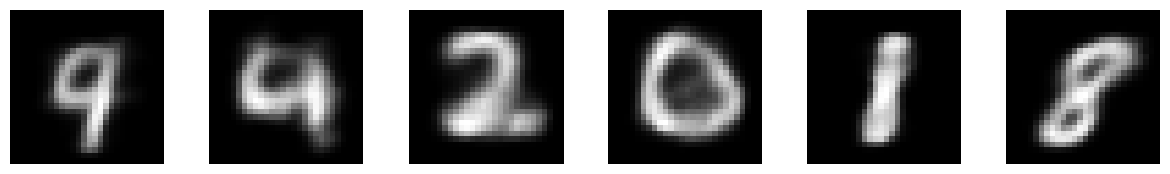


##################################################
VAE-MLP Epoch [7/20], Loss: 147.9722
Sample Images:


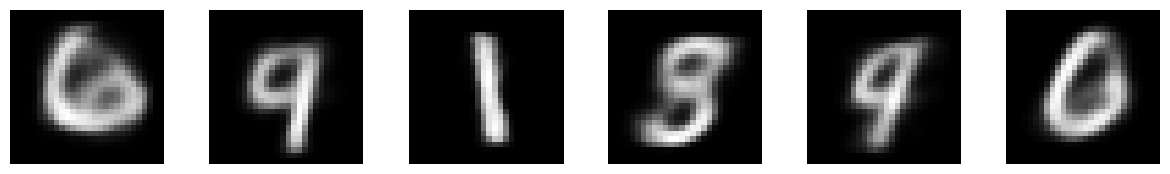


##################################################
VAE-MLP Epoch [8/20], Loss: 146.9047
Sample Images:


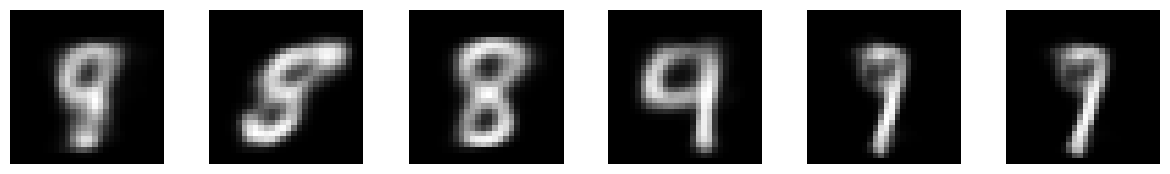


##################################################
VAE-MLP Epoch [9/20], Loss: 146.0481
Sample Images:


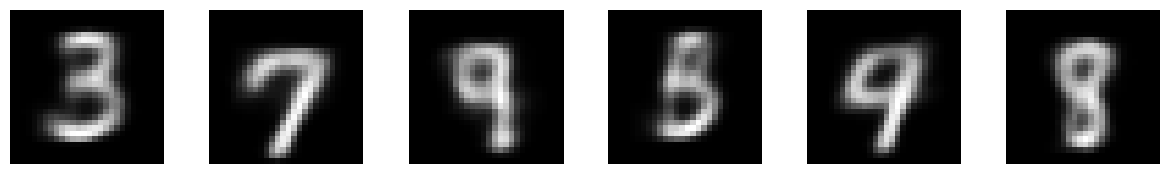


##################################################
VAE-MLP Epoch [10/20], Loss: 145.3775
Sample Images:


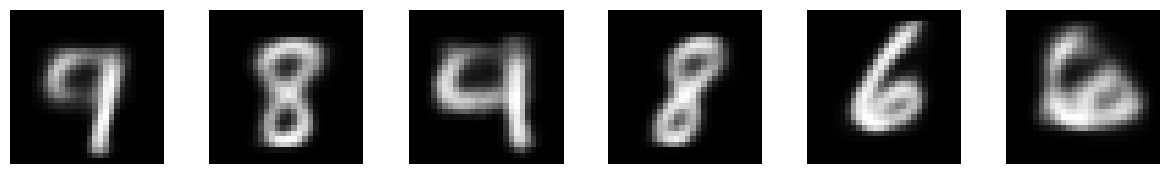


##################################################
VAE-MLP Epoch [11/20], Loss: 144.7440
Sample Images:


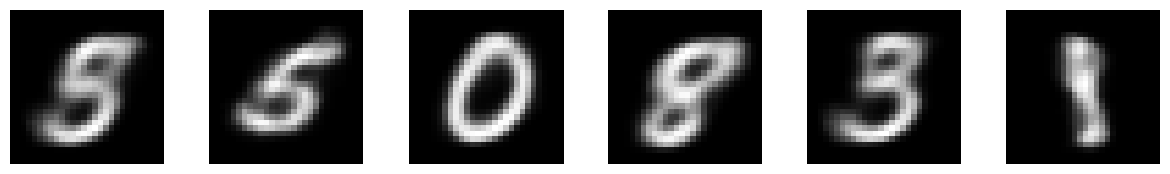


##################################################
VAE-MLP Epoch [12/20], Loss: 144.2098
Sample Images:


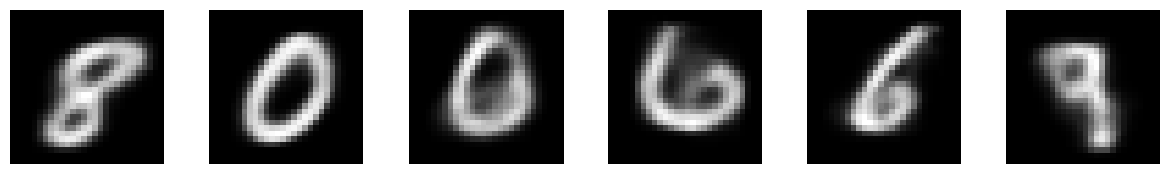


##################################################
VAE-MLP Epoch [13/20], Loss: 143.7038
Sample Images:


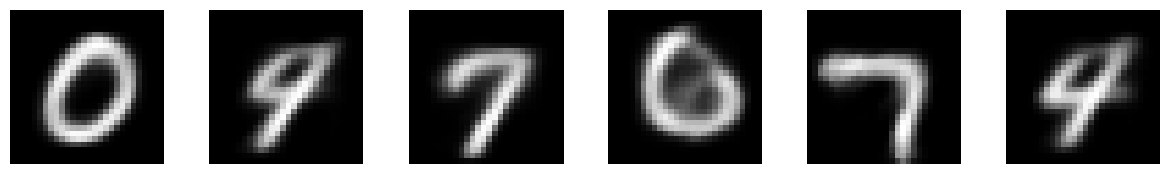


##################################################
VAE-MLP Epoch [14/20], Loss: 143.2785
Sample Images:


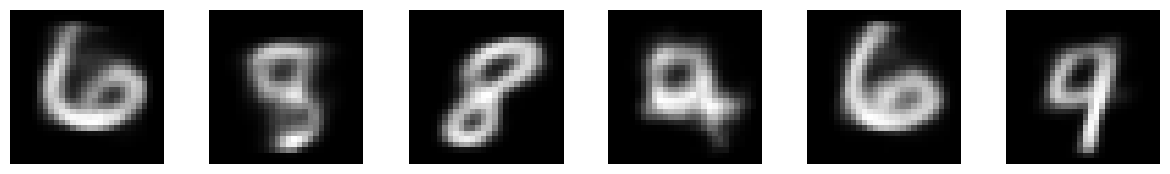


##################################################
VAE-MLP Epoch [15/20], Loss: 142.9172
Sample Images:


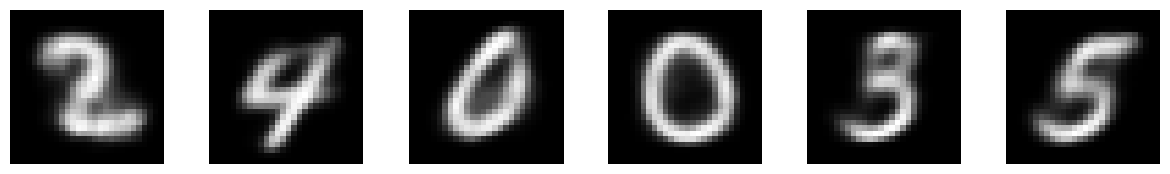


##################################################
VAE-MLP Epoch [16/20], Loss: 142.6146
Sample Images:


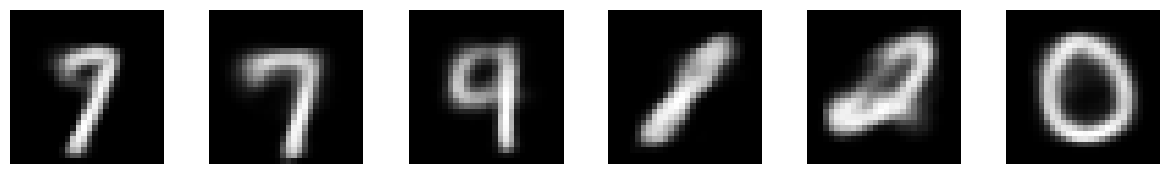


##################################################
VAE-MLP Epoch [17/20], Loss: 142.3898
Sample Images:


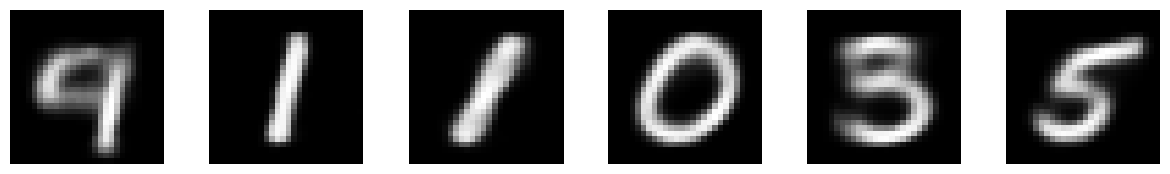


##################################################
VAE-MLP Epoch [18/20], Loss: 142.4840
Sample Images:


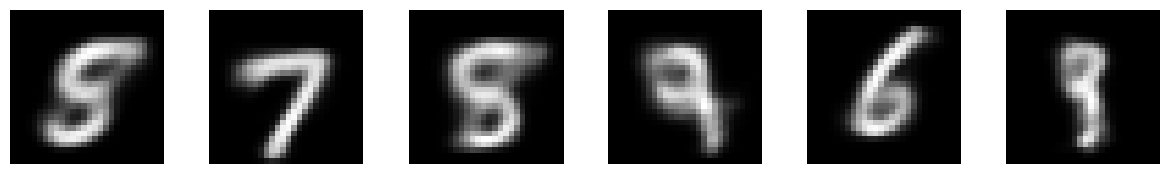


##################################################
VAE-MLP Epoch [19/20], Loss: 141.7453
Sample Images:


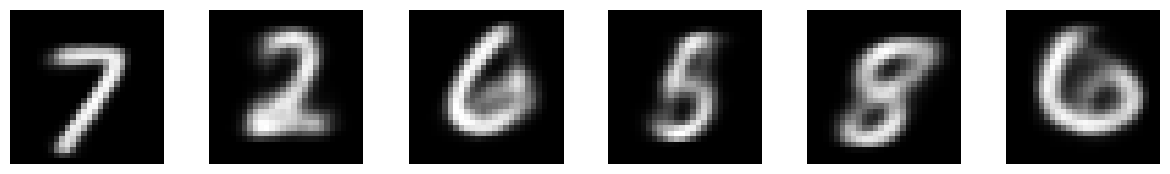


##################################################
VAE-MLP Epoch [20/20], Loss: 141.4773
Sample Images:


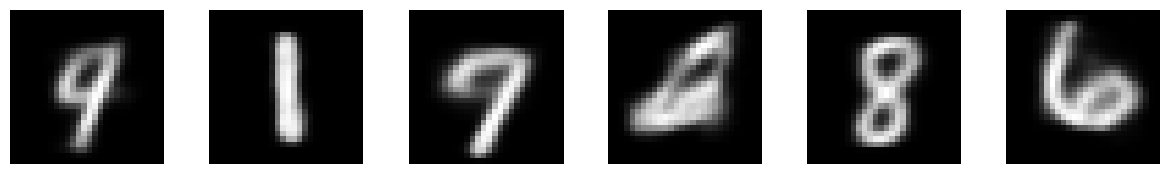

Best model saved as 'best_vae_mlp_model.pth'


In [11]:
# Train VAE-MLP
vae_mlp = VAE_MLP().to(device)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [12]:
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim = 784 , hidden_dims = [256 , 64] , latent_dim = 2, num_classes = 10):
        super(CVAE_MLP, self).__init__()

        # Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_class = nn.Linear(hidden_dims[1], num_classes)

        # Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim),
            nn.Sigmoid()  # Assuming input data is in the range [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # Encoder
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Classifier
        class_logits = self.fc_class(hidden)

        # Decoder
        z_cat = torch.cat([z, y], dim=1)
        reconstructed = self.decoder(z_cat)

        return reconstructed, mu, logvar, class_logits


In [13]:
import torch.nn.functional as F

def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(data.size(0), -1)

    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # Total loss
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss


In [23]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/20], Loss: 168.8375400390625
Sample Images:


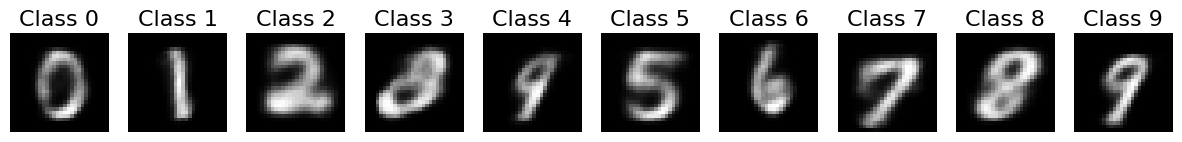


##################################################
CVAE-MLP Epoch [2/20], Loss: 141.58897490234375
Sample Images:


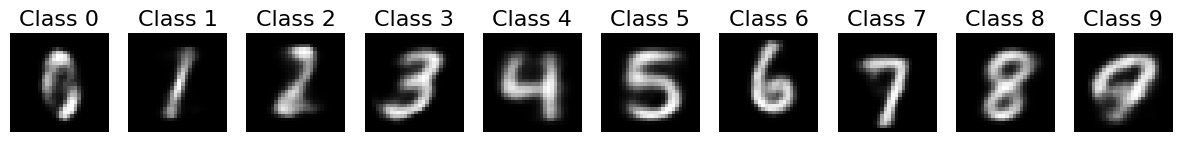


##################################################
CVAE-MLP Epoch [3/20], Loss: 137.39851669108072
Sample Images:


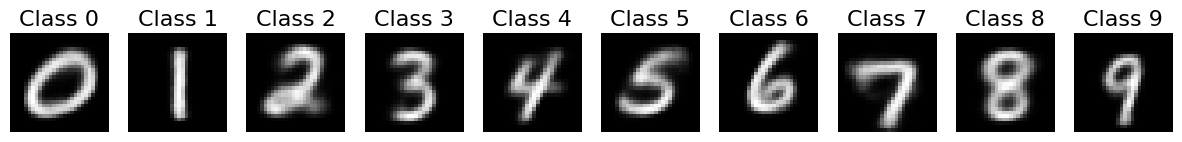


##################################################
CVAE-MLP Epoch [4/20], Loss: 135.30898118489583
Sample Images:


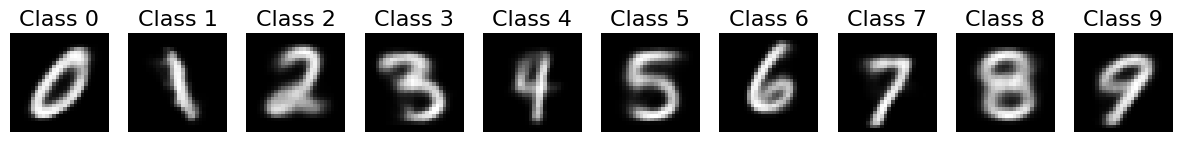


##################################################
CVAE-MLP Epoch [5/20], Loss: 134.04710982259115
Sample Images:


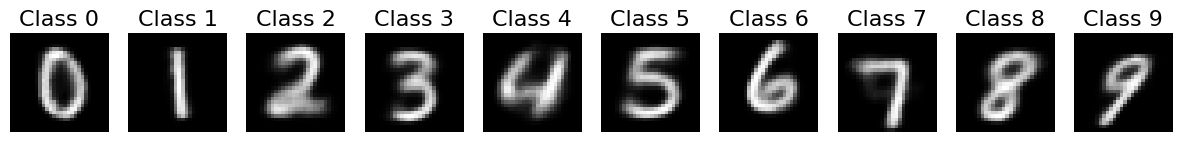


##################################################
CVAE-MLP Epoch [6/20], Loss: 133.1548697998047
Sample Images:


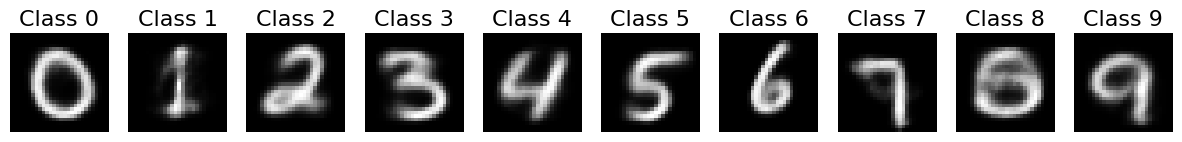


##################################################
CVAE-MLP Epoch [7/20], Loss: 132.43324759114583
Sample Images:


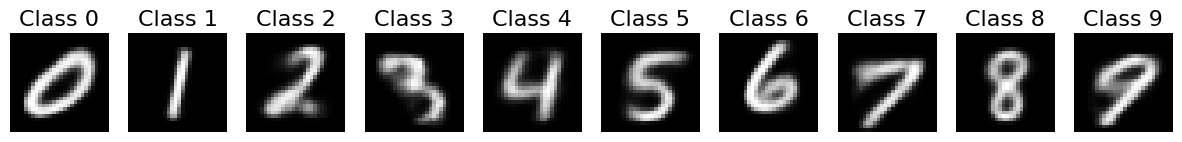


##################################################
CVAE-MLP Epoch [8/20], Loss: 131.90616772460936
Sample Images:


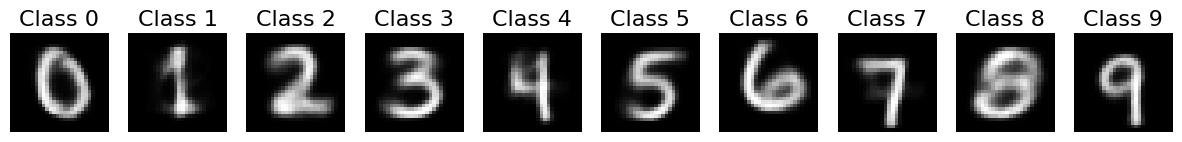


##################################################
CVAE-MLP Epoch [9/20], Loss: 131.5058282796224
Sample Images:


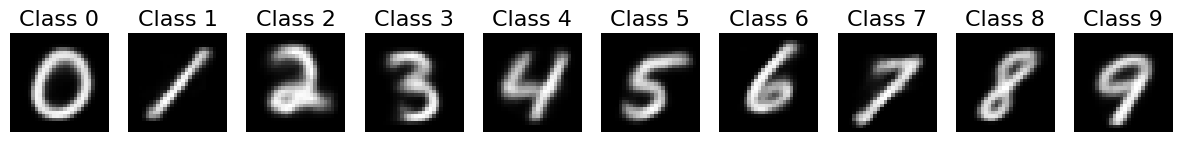


##################################################
CVAE-MLP Epoch [10/20], Loss: 131.10094481608073
Sample Images:


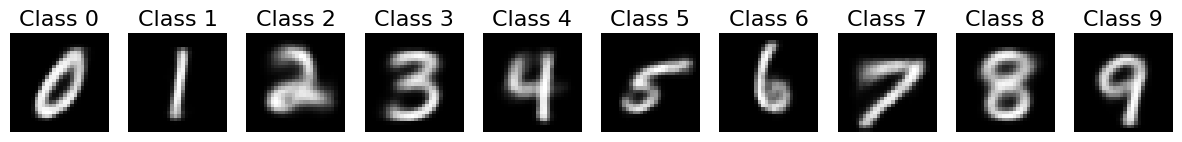


##################################################
CVAE-MLP Epoch [11/20], Loss: 130.8257989868164
Sample Images:


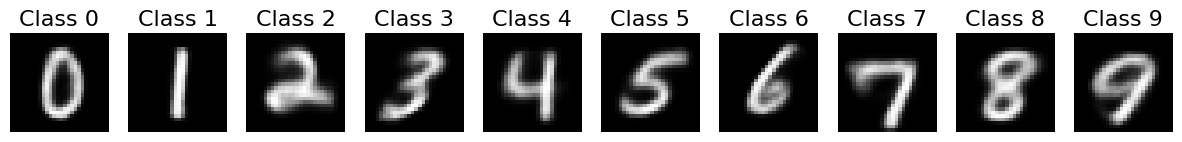


##################################################
CVAE-MLP Epoch [12/20], Loss: 130.58313487141928
Sample Images:


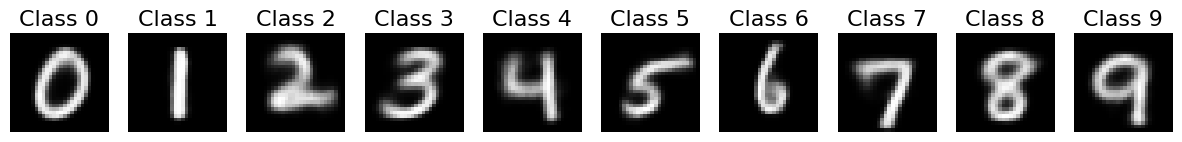


##################################################
CVAE-MLP Epoch [13/20], Loss: 130.30132644042968
Sample Images:


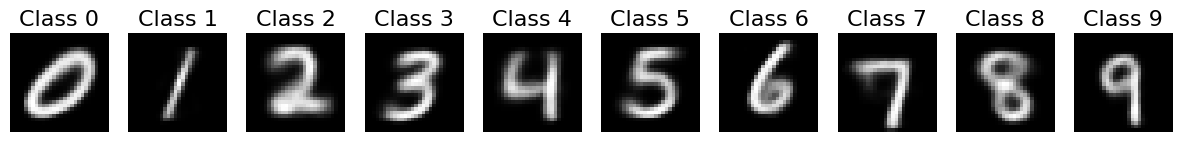


##################################################
CVAE-MLP Epoch [14/20], Loss: 130.05489825846354
Sample Images:


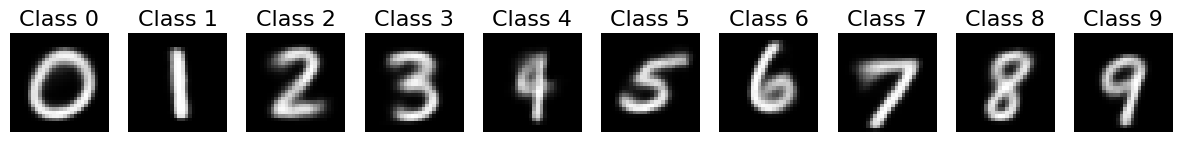


##################################################
CVAE-MLP Epoch [15/20], Loss: 129.8871357421875
Sample Images:


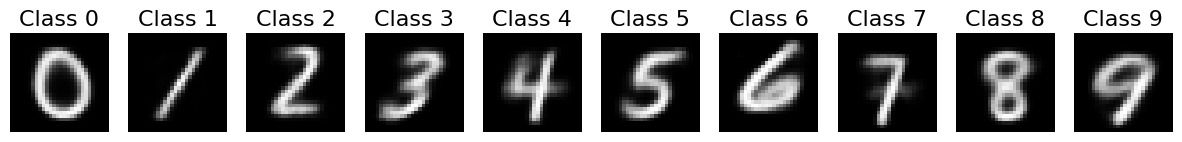


##################################################
CVAE-MLP Epoch [16/20], Loss: 129.66768567301432
Sample Images:


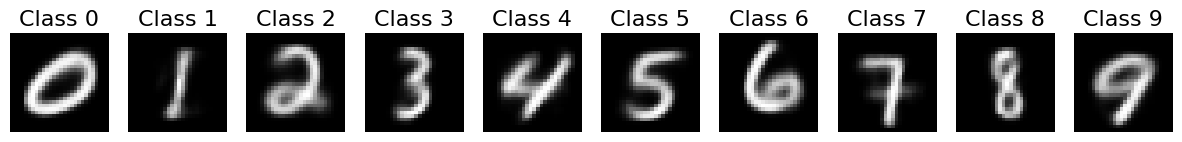


##################################################
CVAE-MLP Epoch [17/20], Loss: 129.49906416422527
Sample Images:


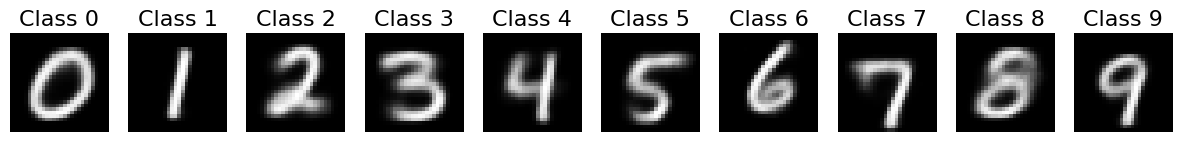


##################################################
CVAE-MLP Epoch [18/20], Loss: 129.391651558431
Sample Images:


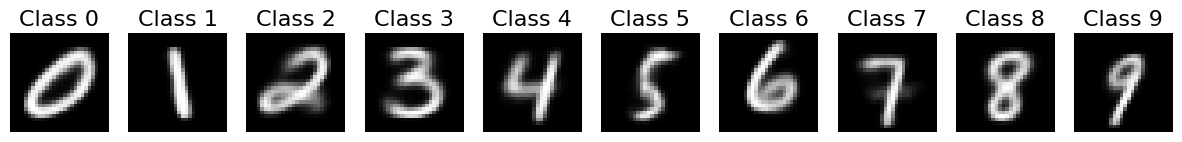


##################################################
CVAE-MLP Epoch [19/20], Loss: 129.2197959391276
Sample Images:


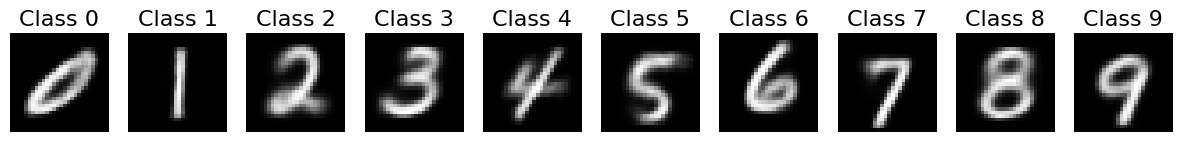


##################################################
CVAE-MLP Epoch [20/20], Loss: 129.05842647705077
Sample Images:


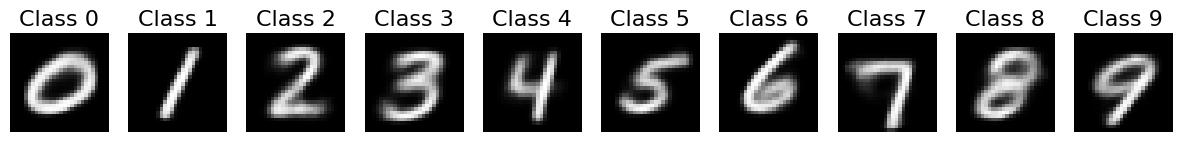

Best model saved as 'best_cvae_mlp_model.pth'


In [24]:
cvae_mlp = CVAE_MLP()
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


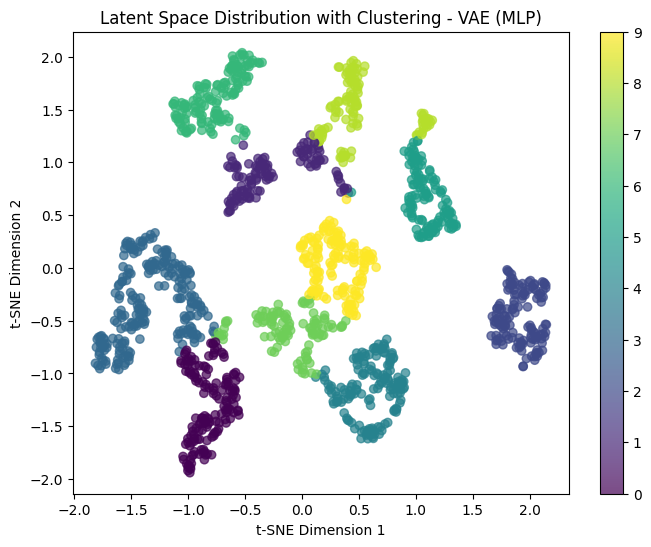

In [17]:
# Load the trained VAE (MLP) model
vae_model = VAE_MLP() 
vae_model.load_state_dict(torch.load('best_vae_mlp_model.pth'))
vae_model.eval()

latent_space = []
labels = []

with torch.no_grad():
    for batch_idx, (data, label) in enumerate(train_loader):
        recon, mu, logvar = vae_model(data)
        latent_space.append(mu.numpy()) 
        labels.append(label.numpy())
        if batch_idx > 20 :
            break

latent_space = np.concatenate(latent_space, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_space)

scaler = StandardScaler()
latent_normalized = scaler.fit_transform(latent_tsne)

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(latent_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(latent_normalized[:, 0], latent_normalized[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Latent Space Distribution - VAE (MLP)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


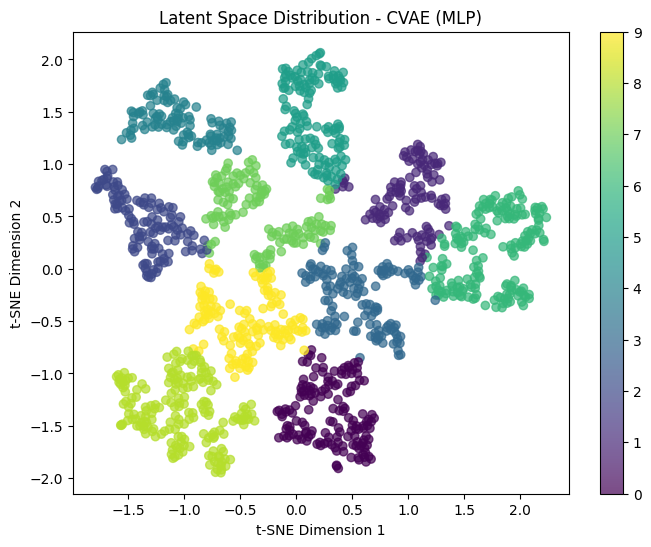

In [25]:
# Load the trained VAE (MLP) model
vae_model = CVAE_MLP()  # Update with your model parameters
vae_model.load_state_dict(torch.load('best_cvae_mlp_model.pth'))
vae_model.eval()

# get latent space representations
latent_space = []
labels = []

with torch.no_grad():
    for batch_idx, (data, label) in enumerate(train_loader):
        labels_one_hot = F.one_hot(label, num_classes=10).float()
        recon, mu, logvar, class_logits = cvae_model(data, labels_one_hot)
        latent_space.append(mu.numpy())
        labels.append(label.numpy())
        if batch_idx > 20 :
            break

latent_space = np.concatenate(latent_space, axis=0)
labels = np.concatenate(labels, axis=0)
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_space)

scaler = StandardScaler()
latent_normalized = scaler.fit_transform(latent_tsne)

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(latent_normalized)

# Scatter plot for Latent Space Distribution 
plt.figure(figsize=(8, 6))
plt.scatter(latent_normalized[:, 0], latent_normalized[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Latent Space Distribution - CVAE (MLP)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()


### Analysis of the latent space distributions indicates that the CVAE performs comparatively well, while the VAE exhibits sparser characteristics. Notably, the CVAE demonstrates a higher level of accuracy.

### Another observation drawn from the latent space analysis reveals that visually similar numbers, such as 1 and 7, tend to be closer together in the latent space representation.
### Both VAEs and CVAEs aim to learn a meaningful latent representation of the input data, CVAEs extend this capability by allowing the model to generate data conditioned on external information, making them suitable for supervised learning scenarios.